In [114]:
# enable auto‑reload so edits in src/ propagate immediately
%load_ext autoreload
%autoreload 2

# now import everything in one line:
from openiex import (
    SystemConfig, Ion, Protein, Inert, ExchangeSystem,
    Method, validate_method,
    initialize_state, load_state, SimulationTracker,
    method_duration, run_simulation, resume_simulation,
    save_simulation, load_simulation, plot_single_species, plot_chromatogram,
    SimulationResult
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [67]:
# binding ions
ions = {
    "Cl-": Ion(
        "Cl-",
        D=1e-10,
        mol_cond=76.3,       # S·cm²/mol
    ),
    "Ac-": Ion(
        "Ac-",
        D=1e-10,
        mol_cond=40.9,
    ),
}

proteins = {
    "em": Protein(
        "em",
        D=5e-12,
        sigma=100,
        nu=5,
        unit="particles/mL",
        ext_coeff_260=12000,
        ext_coeff_280=20000
    ),
    "fu": Protein(
        "fu",
        D=5e-12,
        sigma=100,
        nu=5,
        unit="particles/mL",
        ext_coeff_260=10000,
        ext_coeff_280=18000
    ),
}

inert = {
    "Mg2+": Inert(
        "Mg2+",
        D=0.70e-9,
        mol_cond=53.0,
    ),
    "Na+": Inert(
        "Na+",
        D=1.33e-9,
        mol_cond=50.1,
    ),
}

config = SystemConfig(
    bed_height=0.2,
    column_radius=0.004,
    Lambda=0.5,
    epsilon_i=0.5,
    epsilon_p=0.5,
    Nz=30
)

system = ExchangeSystem(ions, proteins, inert, config)
species_list = list(system.species.keys())
system.set_equilibrium("Cl-", "Ac-", K_eq_val=2.0, k_ads_val=1.0)
system.set_equilibrium("em", "Cl-", K_eq_val=5e3, k_ads_val=1e4)
system.set_equilibrium("em", "Ac-", K_eq_val=5e-2, k_ads_val=1e3)
system.set_equilibrium("fu", "Cl-", K_eq_val=1e4, k_ads_val=1e4)
system.set_equilibrium("fu", "Ac-", K_eq_val=1e-1, k_ads_val=1e3)
system.check_equilibria()

All required equilibria are defined.


In [68]:
buffers = {
    "Load": {"Cl-": 0.04, "Ac-": 0.0, "em": 0, "fu": 5e16, "Mg2+": 0, "Na+": 0},
    "A": {"Cl-": 0.04, "Ac-": 0.0, "em": 0.0, "fu": 0.0, "Mg2+": 0, "Na+": 0},
    "B": {"Cl-": 0.04, "Ac-": 0.3, "em": 0.0, "fu": 0.0, "Mg2+": 0, "Na+": 0},
    "Spike": {"Cl-": 1.0, "Ac-": 0.0, "em": 0.0, "fu": 0.0, "Mg2+": 0, "Na+": 0},
}

# CV = total column volume with no interstitial void correction
blocks = [
    {"buffer_A": "A", "buffer_B": "B", "start_B": 0.0, "end_B": 0.0, "duration_CV": 1, "flow_rate_mL_min": 2.7},
    {"buffer_A": "Spike", "buffer_B": "B", "start_B": 0.0, "end_B": 0.0, "duration_CV": 0.02, "flow_rate_mL_min": 2.7},
    {"buffer_A": "A", "buffer_B": "B", "start_B": 0.0, "end_B": 0.0, "duration_CV": 2, "flow_rate_mL_min": 2.7},
]

method = Method(buffers, blocks)
validate_method(method, system)

In [82]:
import numpy as np

initial_conditions = {
    "Cl-": {"C": 0.04, "Q": system.config.Lambda},
}
y0 = initialize_state(initial_conditions, system)
t_final = method_duration(method, system)
t_eval = np.linspace(0, t_final, 100)

res: SimulationResult = run_simulation(
    y0, t_eval, method, system, 
    integrator='BDF', 
    rtol=1e-3,
    atol=1e-5,
    max_step=0.1
)

Simulating:   0%|          | 0/674.5395677373806 [00:00<?, ?s/s]

In [83]:
save_simulation("results/run4", res)

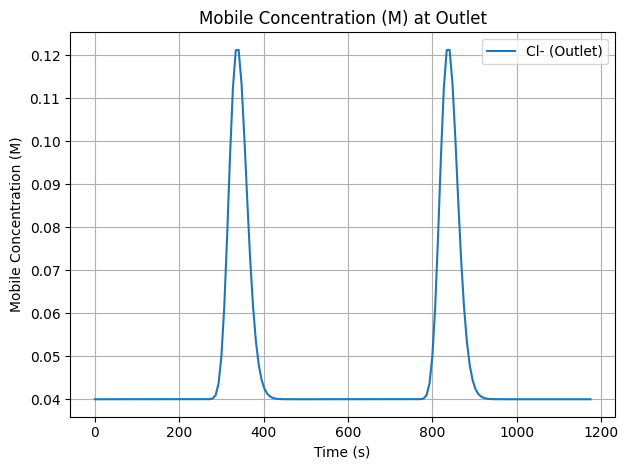

In [99]:
plot_single_species(
    res,
    "Cl-",
    x_axis="time"
)

In [85]:
res_loaded: SimulationResult = load_simulation("results/run4")

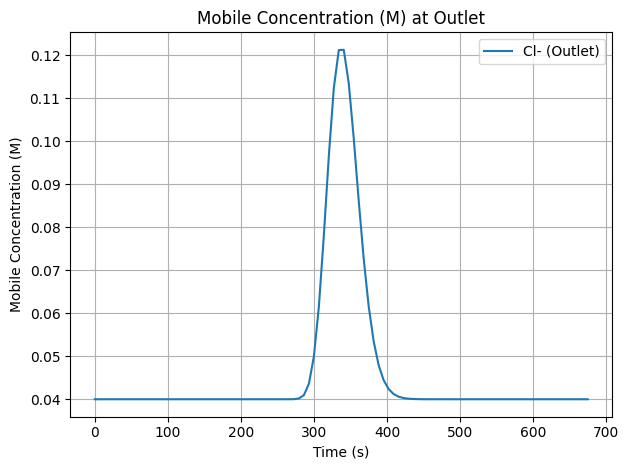

In [90]:
plot_single_species(
    res_loaded,
    "Cl-",
    x_axis="time"
)

In [98]:
# 2) Resume with a new method2
t_final = method_duration(method, system)
t_eval = np.linspace(0, t_final, 100)
res: SimulationResult = resume_simulation(
    res_loaded, t_eval, method, system,
    t_start = 500,        
    integrator='BDF',
    rtol=1e-3,
    atol=1e-5,
    max_step=0.1
)


Simulating:   0%|          | 0/1174.5395677373806 [00:00<?, ?s/s]

In [100]:
save_simulation("results/run4_extended", res)

In [102]:
plot_chromatogram(
    res,
    x_axis='CV',
    time_window=(0, 200),
    plot_uv260=True,
    plot_uv280=True,
    plot_conductivity=True,
    plot_percent_B=True,
    highlight_time=50.0
)

NameError: name 'plot_chromatogram' is not defined